# Data Mining / Prospecção de Dados

## Sara C. Madeira, 2024/2025

# Project 1 - Pattern Mining

## Logistics 
**_Read Carefully_**

**Students should work in teams of 3 people**. 

Groups with less than 3 people might be allowed (with valid justification), but will not have better grades for this reason. 

The quality of the project will dictate its grade, not the number of people working.

**The project's solution should be uploaded in Moodle before the end of `May, 4th (23:59)`.** 

Students should **upload a `.zip` file** containing a folder with all the files necessary for project evaluation. 
Groups should be registered in [Moodle](https://moodle.ciencias.ulisboa.pt/mod/groupselect/view.php?id=139096) and the `zip` file should be identified as `PDnn.zip` where `nn` is the number of your group.

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. You can use `PD_202425_P1.ipynb` as template. In your `.zip` folder you should also include an HTML version of your notebook with all the outputs.**

**Decisions should be justified and results should be critically discussed.** 

Remember that **your notebook should be as clear and organized as possible**, that is, **only the relevant code and experiments should be presented, not everything you tried and did not work, or is not relevant** (that can be discussed in the text, if relevant)! Tables and figures can be used together with text to summarize results and conclusions, improving understanding, readability and concision. **More does not mean better! The target is quality not quantity!**

_**Project solutions containing only code and outputs without discussions will achieve a maximum grade of 10 out of 20.**_

## Dataset and Tools

The dataset to be analysed is **`Foodmart_2025_DM.csv`**, which is a modified and integrated version of the **Foodmart database**, used in several [Kaggle](https://www.kaggle.com) Pattern Mining competitions, with the goal of finding **actionable patterns** by analysing data from the `FOODmart Ltd` company, a leading supermarket chain. 

`FOODmart Ltd` has different types of stores: Deluxe Supermarkets, Gourmet Supermarkets, Mid-Size Grocerys, Small Grocerys and 
Supermarkets. Y

Your **goals** are to find: 
1. **global patterns** (common to all stores) and
2. **local/specific patterns** (related to the type of store).

**`Foodmart_2025_DM.csv`** stores **69549 transactions** from **24 stores**, where **103 different products** can be bought. 

Each transaction (row) has a `STORE_ID` (integer from 1 to 24), and a list of produts (items), together with the quantities bought. 

In the transation highlighted below, a given customer bought 1 unit of soup, 2 of cheese and 1 of wine at store 2.

<img src="Foodmart_2025_DM_Example.png" alt="Foodmart_2025_DM_Example" style="width: 1000px;"/>

In this context, the project has **2 main tasks**:
1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores **(global patterns)**
2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores **(local/specific patterns)**

# **While doing PATTERN and ASSOCIATION MINING keep in mind the following basic/key questions and BE CREATIVE!**

### 1. What are the most popular products?
* I think we could make a semantics to label items, for instance, foods as healthy or unhealthy and such stuff like that to kinda have a more general notion on what people are buying!!!
    
### 2. Which products are bought together?
### 3. What are the frequent patterns?
### 4. Can we find associations highlighting that when people buy a product/set of products also buy other product(s)?
### 5. Are these associations strong? Can we trust them? Are they misleading?
### 6. Can we analyse these patterns and evaluate these associations to find, not only frequent and strong associations, but also interest patterns and associations?

**In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and [`MLxtend`](http://rasbt.github.io/mlxtend/).**

When using `MLxtend`, frequent patterns can either be discovered using `Apriori` and `FP-Growth`. **Choose the pattern mining algorithm to be used.** 

FP-growth is more efficient with larger datasets than apriori; however it can be memory-intensive, especially for datasets with many frequent items. 


## Team Identification

**GROUP 09**

Students:

* Daniel João - *56455*
* Daniel Ribeiro - *64476*
* 

## 1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores

In this first task you should load and preprocessed the dataset **`Foodmart_2025_DM.csv`** in order to compute frequent itemsets and generate association rules considering all the transactions, regardeless of the store, and ignoring product quantities.

We might need to install an older version of *mlxtend* cuz of the issue we saw on the TP classes:

In [1]:
#!pip install mlxtend==0.19

I recommend that all use a conda environment to keep these packages separate:
(in terminal/ bash)
* 1. Create a conda env: **"conda create -n env_name python=3.9"**
* 2. Activate your conda environment: **"conda activate env_name"**
* 3. Install the correct package version: **"conda install -c conda-forge mlxtend=0.19"**  (THIS IS IMPORTANT)
* 4. Install other packages like pandas and such ...
* 5. Install kernel package so you can use this env has a kernel on Jupyter Notebook: **"conda install -c conda-forge ipykernel"**

### 1.0. Used Packages Importing

In [30]:
import csv
import re
import io
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt


# mining patterns
# BEWARE mlxtend version 0.19 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth

# association rules
from mlxtend.frequent_patterns import association_rules

**Set pandas to display all columns of a df:**

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# display columns' content fully
pd.set_option('display.max_colwidth', None)

### 1.1. Load and Preprocess Dataset

**Product quantities and stores should not be considered.**

- Removing STORE_ID info; each row is a transaction.
- Values transformation, from Integer to Boolean (One-Hot Encoding):
    - **True** if value > 1,
    - **False** if value = 0.
- each row is a transaction.

#### 1.1.1. Fixing Malformed Lines 

<ins>Fifty-four lines in the CSV are malformed</ins>, having **missing commas** between product types like the following:

In [4]:
filename = "Foodmart_2025_DM.csv"

In [5]:
pattern = re.compile(r'(?<=[0-9])(?=[A-Za-z])')

# Read the file lines
with open(filename, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Find lines that match the pattern
bad_lines = [line.strip() for line in lines if pattern.search(line)]

# Print the first 10 problematic lines
print("Lines with missing commas (showing first 10):")
for line in bad_lines[:10]:
    print(line)

print(len(bad_lines))

Lines with missing commas (showing first 10):
STORE_ID=2,Soup=1Fresh Vegetables=2,Nasal Sprays=2
STORE_ID=2,Soup=2Milk=1,Deli Meats=1,TV Dinner=2,Pancakes=2
STORE_ID=2,Soup=3Fresh Vegetables=3,Cottage Cheese=1,Juice=2,Frozen Vegetables=2
STORE_ID=2,Soup=1Fresh Vegetables=2,Dips=2,Fresh Fruit=1,Dried Fruit=2,Paper Wipes=1,Anchovies=1
STORE_ID=2,Soup=3Fresh Fruit=2,Lightbulbs=3,Wine=2
STORE_ID=2,Soup=2Eggs=1,Personal Hygiene=2,Fresh Fruit=1,Juice=1
STORE_ID=2,Pasta=2Waffles=2,Nuts=2
STORE_ID=2,Soup=2Eggs=3
STORE_ID=2,Soup=2Cereal=1,Juice=1,Ice Cream=1
STORE_ID=2,Soup=1Fresh Vegetables=2,Frozen Chicken=2,Sour Cream=1,Clams=2
54


**Fixing that (no number should be immediately before a letter, since the malformed lines only have letters after the number) and opening content in the panda's data frame:**

In [6]:
def process_transaction_csv(filename):
    """
    Reads the CSV file containing transactions, fixes missing commas between key-value pairs,
    processes the transactions, and returns a list of transactions.
    Requires:
        - The CSV file at `filename` is accessible and readable.
        - Each line in the file is formatted with key-value pairs in the format "Key=Value".
        - Some rows may be missing commas between consecutive key-value pairs
          (e.g., "Pasta=2Waffles=2" should be "Pasta=2,Waffles=2").
        - The value for each key is numeric, and only keys with a numeric value above 0 should be considered.
        - Keys that start with a specific prefix (e.g., "STORE_ID") are considered auxiliary and will be ignored.
    Ensures: The function returns a list of transactions, where each transaction is a list of keys (products) 
    that had a numeric value greater than 0.
    Returns: list: A list of transactions, each transaction is a list of product keys.
    """

    with open(filename, "r", encoding="utf-8") as f:
        data = f.read()
    data_fixed = re.sub(r'(?<=[0-9])(?=[A-Za-z])', ',', data)
    
    # Create a file-like object from the fixed data.
    csvfile = io.StringIO(data_fixed)
    reader = csv.reader(csvfile, delimiter=',')
    
    dataset = []
    for row in reader:
        transaction = []
        for kv in row:
            if '=' in kv:
                key, value = kv.split('=', 1)
                key = key.strip()
                value = value.strip()
                
                if key.startswith("STORE_ID"):
                    continue
                try:
                    numeric_value = float(value)
                except ValueError:
                    continue
                if numeric_value > 0:
                    transaction.append(key)
        dataset.append(transaction)
    
    return dataset

dataset = process_transaction_csv(filename)
te = TransactionEncoder()
te_ary = te.fit_transform(dataset)
binary_foodmart = pd.DataFrame(te_ary, columns=te.columns_)

binary_foodmart.head(10)

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,Canned Vegetables,Cereal,Cheese,Chips,Chocolate,Chocolate Candy,Clams,Cleaners,Coffee,Cold Remedies,Computer Magazines,Conditioner,Cookies,Cooking Oil,Cottage Cheese,Crackers,Deli Meats,Deli Salads,Deodorizers,Dips,Donuts,Dried Fruit,Dried Meat,Eggs,Fashion Magazines,Flavored Drinks,French Fries,Fresh Chicken,Fresh Fish,Fresh Fruit,Fresh Vegetables,Frozen Chicken,Frozen Vegetables,Gum,Hamburger,Hard Candy,Home Magazines,Hot Dogs,Ibuprofen,Ice Cream,Jam,Jelly,Juice,Lightbulbs,Maps,Milk,Mouthwash,Muffins,Nasal Sprays,Nuts,Oysters,Pancake Mix,Pancakes,Paper Dishes,Paper Wipes,Pasta,Peanut Butter,Personal Hygiene,Pizza,Plastic Utensils,Popcorn,Popsicles,Pot Cleaners,Pot Scrubbers,Pots and Pans,Preserves,Pretzels,Rice,Sardines,Sauces,Screwdrivers,Shampoo,Shellfish,Shrimp,Sliced Bread,Soda,Soup,Sour Cream,Spices,Sponges,Sports Magazines,Sugar,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,Fal

#### 1.1.2. Foodmart Basic Stats

##### Lines and Columns

- Transcation_number = 69549
- Number of Total Product Types (number of columns) = 102

In [7]:
binary_foodmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69549 entries, 0 to 69548
Columns: 102 entries, Acetominifen to Yogurt
dtypes: bool(102)
memory usage: 6.8 MB


##### Are there empty transactions?

Not anymore, before we were having issues due to the problems in the csv.

In [8]:
binary_foodmart[binary_foodmart.sum(axis=1) == 0]

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,Canned Vegetables,Cereal,Cheese,Chips,Chocolate,Chocolate Candy,Clams,Cleaners,Coffee,Cold Remedies,Computer Magazines,Conditioner,Cookies,Cooking Oil,Cottage Cheese,Crackers,Deli Meats,Deli Salads,Deodorizers,Dips,Donuts,Dried Fruit,Dried Meat,Eggs,Fashion Magazines,Flavored Drinks,French Fries,Fresh Chicken,Fresh Fish,Fresh Fruit,Fresh Vegetables,Frozen Chicken,Frozen Vegetables,Gum,Hamburger,Hard Candy,Home Magazines,Hot Dogs,Ibuprofen,Ice Cream,Jam,Jelly,Juice,Lightbulbs,Maps,Milk,Mouthwash,Muffins,Nasal Sprays,Nuts,Oysters,Pancake Mix,Pancakes,Paper Dishes,Paper Wipes,Pasta,Peanut Butter,Personal Hygiene,Pizza,Plastic Utensils,Popcorn,Popsicles,Pot Cleaners,Pot Scrubbers,Pots and Pans,Preserves,Pretzels,Rice,Sardines,Sauces,Screwdrivers,Shampoo,Shellfish,Shrimp,Sliced Bread,Soda,Soup,Sour Cream,Spices,Sponges,Sports Magazines,Sugar,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt


In [9]:
empty_count = 0
for check in dataset:
    if check == []: 
        empty_countcount += 1
if empty_count == 0:
    print('No empty transactions.')

No empty transactions.


##### Are there empty columns?

Just by the way we parsed the binary table it would be impossible to have columns with no transactions.

In [10]:
empty_columns = binary_foodmart.columns[binary_foodmart.sum(axis=0) == 0]

if len(empty_columns) > 0:
	print("Empty columns found:", empty_columns.tolist())
else:
	print("No empty columns found.")

No empty columns found.


##### Mean, maximum, minimum and median products per transaction

In [11]:
# each True is treated as 1
product_counts = binary_foodmart.sum(axis=1)

average_products = product_counts.mean()
max_products = product_counts.max()
min_products = product_counts.min()
median_products = product_counts.median()

print("Mean products per transaction:", average_products)
print("Maximum products in a transaction:", max_products)
print("Minimum products in a transaction:", min_products)
print("Median products per transaction:", median_products)

Mean products per transaction: 4.158435060173403
Maximum products in a transaction: 13
Minimum products in a transaction: 1
Median products per transaction: 4.0


### 1.2. Compute Frequent Itemsets

* Compute frequent itemsets considering a minimum support S_min. 
* Present frequent itemsets organized by length (number of items). 
* List frequent 1-itemsets, 2-itemsets, 3-itemsets, etc with support of at least S < S_min.
* Change the minimum support values and discuss the results.

In [12]:
# higher support items will appear first; descendent order
def compute_frequent_itemset_subsets(df, min_support, algorithm='fp_growth'):
    """
    Compute frequent itemsets from a one-hot encoded DataFrame using a specified algorithm and a minimum support threshold,
    and return the frequent itemsets organizsd by their length as separate DataFrames.
    Parameters:
    df : pandas.DataFrame
        A one-hot encoded DataFrame where each row represents a transaction and each column
        represents an item as a boolean value (True/False).
    min_support : float
        A value between 0 and 1 specifies the minimum fraction of transactions in which an itemset 
        must appear to be considered frequent.
    algorithm: str, optional (default='apriori')
        The algorithm to be used for frequent itemset mining. Supported options are 'apriori' and 'fp_growth'.
    Returns:
        A dictionary mapping each itemset length (e.g., 1, 2, 3, …) to a Ddata fame containing the frequent itemsets
        of that length, with their corresponding support values,
        ordered in descending order so that itemsets with higher support appear first.
    """
    if algorithm == 'apriori':
        frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    elif algorithm == 'fp_growth':
        frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
    else:
        raise ValueError("Unsupported algorithm. Please use 'apriori' or 'fp_growth'.")
    
    frequent_itemsets['itemset_length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    
    # Organize and sort the frequent itemsets by their length.
    subsets = {}
    for length in sorted(frequent_itemsets['itemset_length'].unique()):
        subset_df = frequent_itemsets[frequent_itemsets['itemset_length'] == length]
        # Order the itemset subset by support in descending order.
        subset_df = subset_df.sort_values(by='support', ascending=False)
        subsets[length] = subset_df
        
    return subsets


**Visualise length itemsets with a key that equals their itemset partition length.**

#### 1.2.0. What Mining Algorithm to Use?

Much faster using FP-Growth.

As expected, when the minimum support threshold is as low as 0.1%, the <ins>FP-Growth algorithm demonstrates significantly faster performance compared to Apriori</ins> because it leverages an efficient data structure known as the FP tree. 

Unlike the Apriori algorithm that generates **candidate itemsets**, **FP-growth compacts the representation of the transactional dataset**, minimising the need for exhaustive candidate generation, and allowing the algorithm to bypass the aforementioned combinatorial explosion. 

Therefore, FP-Growth quickly identifies frequent patterns even amidst a large number of potential itemsets, leading to improvements in execution time under such low support conditions. The computational time improvements are comparatively plotted in the following graph:

In [21]:
support_thresholds = [0.05, 0.04, 0.03, 0.02, 0.01, 0.0075, 0.005]
results = []

for support in support_thresholds:
    start_time = time.time()
    _ = compute_frequent_itemset_subsets(binary_foodmart, min_support=support, algorithm='apriori')
    apriori_time = time.time() - start_time
    results.append({'Support': support * 100, 'Time': apriori_time, 'Algorithm': 'Apriori'})
    
    start_time = time.time()
    _ = compute_frequent_itemset_subsets(binary_foodmart, min_support=support, algorithm='fp_growth')
    fpgrowth_time = time.time() - start_time
    results.append({'Support': support * 100, 'Time': fpgrowth_time, 'Algorithm': 'FP-Growth'})


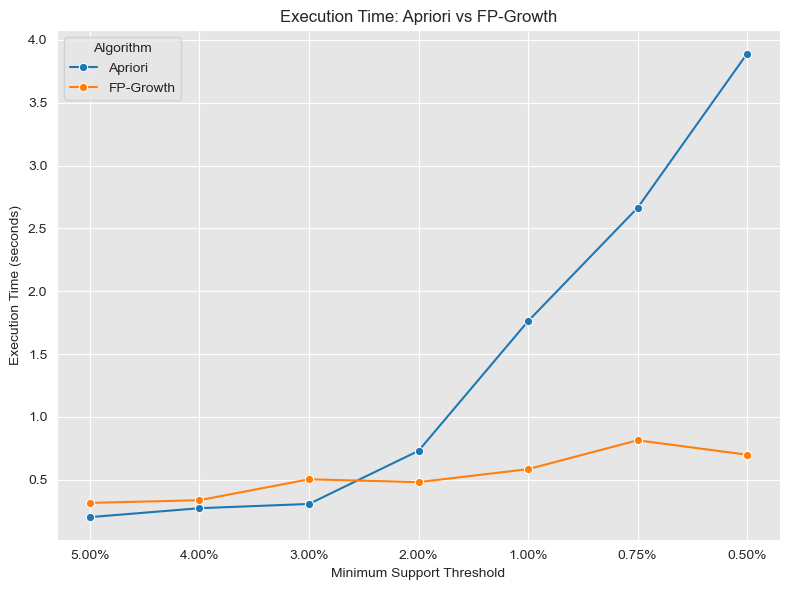

In [ ]:
df_times = pd.DataFrame(results)
df_times['Support_label'] = df_times['Support'].map(lambda x: f"{x:.2f}%")

support_order = sorted(df_times['Support_label'].unique(),
                       key=lambda s: float(s.strip('%')), reverse=True)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(8, 6))

ax = sns.lineplot(
    data=df_times,
    x='Support_label',
    y='Time',
    hue='Algorithm',
    marker='o',
    sort=False  
)

ax.set_title('Execution Time: Apriori vs FP-Growth')
ax.set_xlabel('Minimum Support Threshold')
ax.set_ylabel('Execution Time (seconds)')
ax.set_xticks(support_order)
ax.set_xticklabels(support_order)
plt.tight_layout()
plt.show()

#### 1.2.1. Minimum Support Threshold

**Support** is the proportion of transactions in a dataset that contain a specific itemset.  
For example, if an itemset appears in 5 out of 10 transactions, its support is 0.5 or 50%.

The **minimum support threshold** is the cutoff that we set;
<ins>any itemset with support below this value is discarded</ins>, while those above it are considered ***frequent*** and are used to generate association rules.

Nonetheless, it’s important to understand that **support is a relative metric**, depending on the total number of transactions in the dataset.

- A `0.5%` minimum support means an itemset must appear in **at least ~348 transactions** to be considered frequent.  
  This can be a significant threshold, especially for **larger itemsets**, which naturally occur less often.

- In contrast, a `0.01%` minimum support means an itemset only needs to appear in **about 7 transactions**.  
  This can allow **too many low-frequency or noisy patterns** into the results, which may bloat the output and reduce the overall quality of insights.

To choose a practical minimum support, it's useful to plot the number of frequent itemsets against varying thresholds. **As minimum support decreases, the number of patterns typically grows exponentially**. The ***“elbow point”*** in this curve <ins>is where the growth rate sharply increases, suggesting a balanced threshold that captures meaningful patterns</ins> without introducing excessive noise.

To select a practical **minimum-support threshold**, it's to plot the number of frequent itemsets againstof the varying support threshold. As the support is lowered, the count of frequent itemsets typically grows *(often exponentially)*, producing a sharp inflection, aka a **“elbow point”** , in the curve. This elbow marks a **sweet spot**: 
 * **it captures most of the meaningful patterns** 
 * **while avoiding an explosion (exponential growth) of trivial or noisy itemsets**.


In [37]:
# Lists to store results
min_sup_values = []
itemset_counts = []

# Generate thresholds from 5.0% to 0.1% in 0.1% steps (i.e., 0.001 in fraction)
for min_sup in np.arange(0.05, 0.0009, -0.001):
    try:
        frequent_itemsets = fpgrowth(binary_foodmart, min_support=min_sup, use_colnames=True)
        num_itemsets = len(frequent_itemsets)
        min_sup_values.append(round(min_sup * 100, 3))  # Convert to percentage
        itemset_counts.append(num_itemsets)
    except Exception as e:
        print(f"Error at min_sup = {min_sup*100:.3f}%: {e}")
        break

# Create a DataFrame of results
results_df = pd.DataFrame({
    'Minimum Support (%)': min_sup_values,
    'Number of Frequent Itemsets': itemset_counts
})

results_df['Jump'] = results_df['Number of Frequent Itemsets'].diff().fillna(0).astype(int)
results_df

,Minimum Support (%),Number of Frequent Itemsets,Jump
0,5.0,32,0
1,4.9,33,1
2,4.8,33,0
3,4.7,33,0
4,4.6,33,0
5,4.5,33,0
6,4.4,33,0
7,4.3,33,0
8,4.2,35,2
9,4.1,39,4


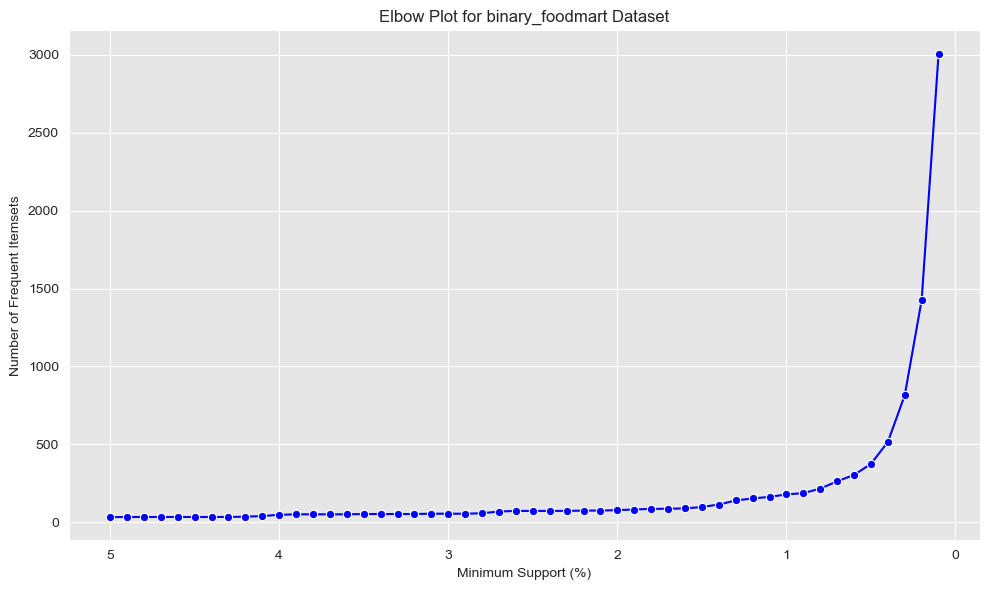

In [35]:
# Plot the elbow curve
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(10, 6))
sns.lineplot(x='Minimum Support (%)', y='Number of Frequent Itemsets', data=results_df, marker='o', color='blue')
plt.xlabel('Minimum Support (%)')
plt.ylabel('Number of Frequent Itemsets')
plt.title('Elbow Plot for binary_foodmart Dataset')
plt.gca().invert_xaxis()  # Higher support on the left
plt.grid(True)
plt.tight_layout()
plt.show()

##### Elbow Point Results

- **5.0% → 3.0%**: Slow growth (32 → 54 itemsets), capturing only the most frequent patterns.  
- **3.0% → 2.0%**: Moderate growth (54 → 77), still manageable.  
- **2.0% → 1.5%**: Slight uptick (77 → 97).  
- **1.5% → 1.0%**: Noticeable jump (97 → 178), marking the start of steeper growth.  
- **1.0% → 0.5%**: More than doubles (178 → 374).  
- **0.5% → 0.1%**: Explosive increase (374 → 3009), indicating many rare/noisy itemsets.

Based on this, the elbow point appears to be around 1.5% to 1.0%, because this range balances pattern coverage and noise:

- **1.5%** yields **97** itemsets— compact, high‑confidence patterns.  
- **1.0%** yields **178** itemsets- broader coverage yet still manageable.  
- **0.5%** yields **374** itemsets— much broader coverage, may not be manageable.  
- <ins>Below 1.0%, itemsets explode, burdening computation and including trivial rules</ins>.

##### Minimum Support Threshold = 5%

In [39]:
S_min_high = 0.05
frequent_subsets_high = compute_frequent_itemset_subsets(binary_foodmart, S_min_high)
print("Frequent itemsets can be partioned in",len(frequent_subsets_high), "itemsets of differing lengths.")

Frequent itemsets can be partioned in 2 itemsets of differing lengths.


In [40]:
print("Frequent itemsets of 1 item")
frequent_subsets_high[1].sort_values(by='support', ascending=False)

Frequent itemsets of 1 item


,support,itemsets,itemset_length
1,0.284461,(Fresh Vegetables),1
12,0.175286,(Fresh Fruit),1
0,0.120059,(Soup),1
3,0.117845,(Cheese),1
14,0.117227,(Dried Fruit),1
4,0.105422,(Cookies),1
29,0.080677,(Wine),1
15,0.078966,(Paper Wipes),1
20,0.078549,(Canned Vegetables),1
22,0.068340,(Frozen Vegetables),1


In [41]:
print("Frequent itemsets of 2 items")
frequent_subsets_high[2]

Frequent itemsets of 2 items


,support,itemsets,itemset_length
31,0.050971,"(Fresh Vegetables, Fresh Fruit)",2


##### **Mininum Support Threshhold = 1%**

In [42]:
S_min_high = 0.01
frequent_subsets_high = compute_frequent_itemset_subsets(binary_foodmart, S_min_high)
print("Frequent itemsets can be partioned in",len(frequent_subsets_high), "itemsets of differing lengths.")

Frequent itemsets can be partioned in 2 itemsets of differing lengths.


In [43]:
print("Frequent itemsets of 1 item")
frequent_subsets_high[1].sort_values(by='support', ascending=False)

Frequent itemsets of 1 item


,support,itemsets,itemset_length
2,0.284461,(Fresh Vegetables),1
29,0.175286,(Fresh Fruit),1
0,0.120059,(Soup),1
5,0.117845,(Cheese),1
32,0.117227,(Dried Fruit),1
...,...,...,...
100,0.013343,(Sardines),1
34,0.013271,(Sauces),1
83,0.013156,(Fashion Magazines),1
95,0.012998,(Pancakes),1


In [44]:
print("Frequent itemsets of 2 items")
frequent_subsets_high[2].sort_values(by='support', ascending=False)

Frequent itemsets of 2 items


,support,itemsets,itemset_length
134,0.050971,"(Fresh Vegetables, Fresh Fruit)",2
102,0.035701,"(Soup, Fresh Vegetables)",2
138,0.035284,"(Fresh Vegetables, Dried Fruit)",2
110,0.031201,"(Fresh Vegetables, Cheese)",2
112,0.027765,"(Fresh Vegetables, Cookies)",2
...,...,...,...
121,0.010281,"(Fresh Vegetables, Cleaners)",2
157,0.010194,"(Frozen Vegetables, Fresh Fruit)",2
155,0.010165,"(Popcorn, Fresh Vegetables)",2
175,0.010137,"(Wine, Dried Fruit)",2


##### Minimum Support Threshold = 0.5%



In [57]:
S_min_high = 0.005
frequent_subsets_high = compute_frequent_itemset_subsets(binary_foodmart, S_min_high, "fp_growth")
print("Frequent itemsets can be partioned in",len(frequent_subsets_high), "itemsets of differing lengths.")

Frequent itemsets can be partioned in 3 itemsets of differing lengths.


In [58]:
print("Frequent itemsets of 1 item")
frequent_subsets_high[1].sort_values(by='support', ascending=False)

Frequent itemsets of 1 item


,support,itemsets,itemset_length
2,0.284461,(Fresh Vegetables),1
29,0.175286,(Fresh Fruit),1
0,0.120059,(Soup),1
5,0.117845,(Cheese),1
32,0.117227,(Dried Fruit),1
...,...,...,...
100,0.013343,(Sardines),1
34,0.013271,(Sauces),1
83,0.013156,(Fashion Magazines),1
95,0.012998,(Pancakes),1


In [59]:
print("Frequent itemsets of 2 items")
frequent_subsets_high[2].sort_values(by='support', ascending=False)

Frequent itemsets of 2 items


,support,itemsets,itemset_length
212,0.050971,"(Fresh Vegetables, Fresh Fruit)",2
102,0.035701,"(Fresh Vegetables, Soup)",2
224,0.035284,"(Fresh Vegetables, Dried Fruit)",2
122,0.031201,"(Cheese, Fresh Vegetables)",2
129,0.027765,"(Fresh Vegetables, Cookies)",2
...,...,...,...
157,0.005018,"(Dips, Cookies)",2
329,0.005018,"(Frozen Chicken, Cookies)",2
301,0.005004,"(Lightbulbs, Paper Wipes)",2
109,0.005004,"(Cheese, Pasta)",2


In [60]:
print("Frequent itemsets of 3 items")
frequent_subsets_high[3].sort_values(by='support', ascending=False)

Frequent itemsets of 3 items


,support,itemsets,itemset_length
104,0.007089,"(Fresh Vegetables, Fresh Fruit, Soup)",3
134,0.005550,"(Fresh Vegetables, Fresh Fruit, Cookies)",3
123,0.005334,"(Cheese, Fresh Vegetables, Fresh Fruit)",3


#### 1.2.2. Discussing Results

Initially, setting the minimum support threshold to **5%** resulted in a relatively limited set of frequent itemsets. In this configuration, only strong individual items emerged as frequent, and a single pair, ‘fresh fruit and fresh vegetables’, was identified as a frequent 2‑itemset. This outcome shows that a higher support level filters out less common or weaker associations, ensuring that only the most dominant patterns (that appear in a substantial fraction of transactions) are retained. **This characteristic is particularly beneficial when the analysis seeks to focus exclusively on the most robust and reliable associations.**

As the threshold was lowered to **1%**, a notable increase in the detected number of frequent itemsets was observed. Frequent 1‑itemsets expanded significantly to include a broader range of items, and the discovery of 2‑itemsets increased, revealing more nuanced co‑occurrence patterns that were previously hidden. At this support level in our dataset, itemsets must occur in at least ~695 transactions (by no means a trivial requirement), yet it still uncovers associations of significant potential value.

When the support threshold was further reduced to **0.5%**, the results demonstrated an even more dramatic increase in the number of frequent itemsets, including the emergence of 3‑itemsets. Under these conditions, the algorithm captured a vast array of item combinations, revealing more intricate interactions among products. However, lowering support this far also introduces the risk of **statistically insignificant patterns**, as noise may start to seep in.

Setting the support threshold to approximately **1.5%** or **1%** yields leaner, more significant rule sets with minimal computational overhead: the algorithm returns a compact collection of frequent itemsets while excluding less common—and often less meaningful—patterns. 

In contrast, lowering the threshold to **0.5%** (the elbow point) uncovers a substantially larger number of itemsets, with the jump compared to the previous step being much higher and including frequent itemsets of size 3. Nonetheless, this richer variety may also contain noise.

Setting it to anything **lower than 0.5%** would probably have too much noise and bloat associated to it, so we decided against it.


The objective of applying filtering mechanisms in association rule mining is to ensure the extraction of patterns that are both statistically and contextually meaningful. In practice, meaningful patterns are those that lead to actionable insights. For example, a rule such as `{diapers} → {baby wipes}` with high confidence and lift may justify strategic decisions like co-locating these products in a retail environment. In contrast, a rule like `{milk} → {toothpaste}` with low lift might merely indicate that both items are commonly purchased, without implying a true relationship. Such patterns, although frequent, do not offer valuable insights and can be considered noise.

Lowering the minimum support threshold expands the search space and increases the likelihood of identifying spurious associations—patterns that occur by chance and lack substantive interpretability. To mitigate this, robust filtering is necessary. Evaluation metrics such as **confidence**, **lift**, and **conviction** serve as essential tools for discerning the strength and reliability of the generated rules. These measures help eliminate statistically weak or misleading patterns, ensuring that the final set of rules reflects genuine relationships within the data.

By applying these filters, the rule mining process yields results that are both interpretable and actionable, thereby enhancing the quality and utility of the analysis.




### 1.3. Generate Association Rules from Frequent Itemsets

Using a minimum support S_min fundamented by the previous results. 
* Generate association rules with a choosed value (C) for minimum confidence. 
* Generate association rules with a choosed value (L) for minimum lift. 
* Generate association rules with both confidence >= C and lift >= L.
* Change C and L when it makes sense and discuss the results.
* Use other metrics besides confidence and lift.
* Evaluate how good the rules are given the metrics and how interesting they are from your point of view.

#### 1.3.1 Association Rules for Confidence

**Confidence**: is a measure of <ins>how often items in a rule are found together</ins>.
* Confidence helps you rank rules by how strong they are.
* But confidence does not account for the overall frequency of B (for that, we use lift).

$$
\text{Confidence}(A \rightarrow B) = \frac{\text{Support}(A \cup B)}{\text{Support}(A)}
$$

**Interpretation of Confidence:**

**Confidence** tells you the probability that **B** will be purchased (or occur) if **A** is purchased (or occurs).

- **High Confidence (close to 1)**: This means that **B** is very likely to appear in transactions that already contain **A**. This implies a strong association between **A** and **B**.
  
- **Low Confidence (close to 0)**: This means that **B** is not likely to appear in transactions that contain **A**. In this case, the association between **A** and **B** is weak.


maybe we should use a lower support like 0.1% or 0.01%, even thought some patterns might be rare they may still be valuable


Since the support minimum <ins>threshold level of 5% didn't display but one pair of items</ins> (only 1 item set of size 2, the rest were only 1 item), the value chosen for the association rules for confidence was lowered to 1%, a percentage that has relatively plenty of item pairs to display — which will form the association rules —, and also a relatively fast computation using FP-Growth. Now, let's form the confidence association rules.

##### **testing different supports**

In mlxtend's built-in association_rules function, the default metric is confidence, with a default minimum threshold of 0.8 (or 80%).

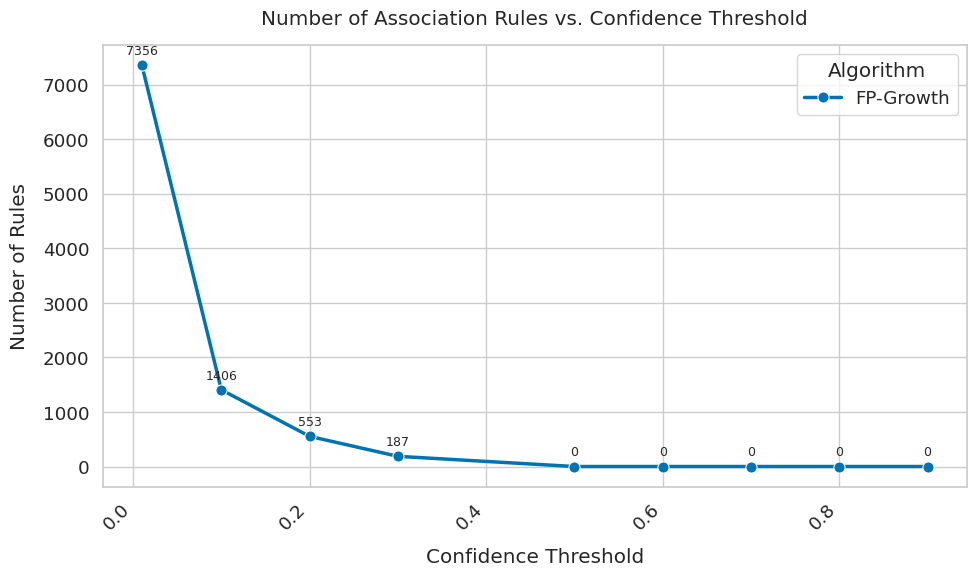

In [53]:
supp = 0.001
conf_thresholds = [0.01,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9]
records = []

for thresh in conf_thresholds:
    freq = fpgrowth(binary_foodmart, min_support=supp, use_colnames=True)
    rules = association_rules(freq, metric="confidence", min_threshold=thresh)
    records.append({
        "confidence_threshold": thresh,
        "rule_count": len(rules),
        "algorithm": "FP-Growth"
    })

df_counts = pd.DataFrame(records)

# 2. Theme & context
sns.set_theme(style="whitegrid")                    # cohesive styling :contentReference[oaicite:12]{index=12}
sns.set_context("notebook", font_scale=1.2)         # scale up :contentReference[oaicite:13]{index=13}

# 3. Plot
palette = "colorblind"
dashes = {"FP-Growth": ""}

plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=df_counts,
    x="confidence_threshold",
    y="rule_count",
    hue="algorithm",
    palette=palette,
    style="algorithm",
    dashes=dashes,
    markers=True,
    linewidth=2.5,
    markersize=8
)

# 4. Annotate
for _, row in df_counts.iterrows():
    ax.text(
        row["confidence_threshold"], 
        row["rule_count"] + df_counts["rule_count"].max() * 0.02,
        f"{row['rule_count']}", 
        ha="center", 
        va="bottom",
        fontsize=9
    )

# 5. Labels & legend
ax.set_title("Number of Association Rules vs. Confidence Threshold", pad=15)
ax.set_xlabel("Confidence Threshold", labelpad=10)
ax.set_ylabel("Number of Rules", labelpad=10)
plt.xticks(rotation=45, ha="right")
ax.legend(title="Algorithm", loc="upper right", frameon=True)
plt.tight_layout()
plt.show()


In [ ]:

frequent_subsets_01 = fpgrowth(binary_foodmart, min_support=supp, use_colnames=True)

rules_01 = association_rules(frequent_subsets_01)

# Print the generated association rules for confidence
rules_01

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


##### **original**

In [23]:
supp = 0.01

frequent_subsets = fpgrowth(binary_foodmart, min_support=supp)

#Now the association rules
conf = 0.1
rules_01 = association_rules(frequent_subsets, metric="confidence", min_threshold=conf)

# Print the generated association rules for confidence
rules_01
rules_01.sort_values(by='confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
865,"(81, 68)",(40),0.002444,0.284461,0.001136,0.464706,1.633635,0.000441,1.336721
1213,"(2, 31)",(40),0.003336,0.284461,0.001438,0.431034,1.515266,0.000489,1.257613
1060,"(75, 93)",(40),0.002818,0.284461,0.001208,0.428571,1.506607,0.000406,1.252193
24,"(65, 26)",(40),0.003091,0.284461,0.001308,0.423256,1.487920,0.000429,1.240652
460,"(7, 15)",(40),0.003264,0.284461,0.001366,0.418502,1.471210,0.000437,1.230510
...,...,...,...,...,...,...,...,...,...
1087,"(22, 31)",(59),0.012883,0.067176,0.001294,0.100446,1.495280,0.000429,1.036986
115,(22),(12),0.105422,0.117845,0.010582,0.100382,0.851813,-0.001841,0.980588
1152,(100),(22),0.080677,0.105422,0.008081,0.100160,0.950089,-0.000424,0.994153
127,"(86, 22)",(12),0.012639,0.117845,0.001265,0.100114,0.849538,-0.000224,0.980296


**We have 89 association rules with a minimum confidence of 0.1 and going up to >0.3. So, let's create association rules with a minimum confidence value up to 0.3.**
**First we will create the function to retrieve the antecedents and consequent item names with the respective confidence level.**

In [63]:
# Function to get item names from indices 
def get_formatted_rules(rules_df, binary_data):
    """
    Formats an existing DataFrame of association rules with item names
    and selects specific columns.

    Args:
        rules_df (pd.DataFrame): DataFrame of association rules
                                   generated by association_rules.
        binary_data (pd.DataFrame): Original binary encoded DataFrame
                                     where columns are item names.

    Returns:
        pd.DataFrame: Formatted DataFrame of association rules with item names,
                      antecedent support, consequent support, and confidence.
    """
    item_names = binary_data.columns

    def get_item_names(item_indices, data_columns):
        items = [data_columns[i] for i in item_indices]
        return frozenset(items)

    rules_df['antecedents_names'] = rules_df['antecedents'].apply(lambda x: get_item_names(x, item_names))
    rules_df['consequents_names'] = rules_df['consequents'].apply(lambda x: get_item_names(x, item_names))

    formatted_rules = rules_df[['antecedents_names', 'consequents_names', 'antecedent support', 'consequent support', 'confidence']]

    return formatted_rules

In [67]:
#Retriving the first association rules with confidence minimum=0.1
get_formatted_rules(rules_01, binary_foodmart)

,antecedents_names,consequents_names,antecedent support,consequent support,confidence
0,(Fresh Vegetables),(Soup),0.284461,0.120059,0.125505
1,(Soup),(Fresh Vegetables),0.120059,0.284461,0.297365
2,(Soup),(Fresh Fruit),0.120059,0.175286,0.173293
3,(Fresh Fruit),(Soup),0.175286,0.120059,0.118694
4,(Pasta),(Fresh Vegetables),0.049217,0.284461,0.270815
...,...,...,...,...,...
84,(Wine),(Fresh Vegetables),0.080677,0.284461,0.254500
85,(Wine),(Fresh Fruit),0.080677,0.175286,0.185707
86,(Wine),(Dried Fruit),0.080677,0.117227,0.125646
87,(Pizza),(Fresh Vegetables),0.054048,0.284461,0.283054


**Now we'll create a for loop for the different confidence minimum thresholds up to 0.3.**

In [65]:
# To generate the association rules let's use a for loop with different confidence levels (0.1, 0.15, 0.2, 0.3)

# Define the list of lift thresholds you want to use
confidence_thresholds = [0.1, 0.15, 0.2, 0.3]

# Dictionary to store formatted rules for each confidence threshold
formatted_rules_by_conf = {}

# Loop over each confidence value, get the rules and print them
for conf_value in confidence_thresholds:
    # Get association rules with the current confidence threshold
    rules = association_rules(frequent_subsets, metric="confidence", min_threshold=conf_value)
    
    # Format the rules
    formatted_rules = get_formatted_rules(rules, binary_foodmart)
    
    # Save the formatted rules into the dictionary
    formatted_rules_by_conf[conf_value] = formatted_rules
    
    # Display the results
    print(f"Formatted rules for lift threshold = {conf_value}:")
    print(formatted_rules)
    print("\n" + "-"*50 + "\n")

Formatted rules for lift threshold = 0.1:
     antecedents_names   consequents_names  antecedent support  \
0   (Fresh Vegetables)              (Soup)            0.284461   
1               (Soup)  (Fresh Vegetables)            0.120059   
2               (Soup)       (Fresh Fruit)            0.120059   
3        (Fresh Fruit)              (Soup)            0.175286   
4              (Pasta)  (Fresh Vegetables)            0.049217   
..                 ...                 ...                 ...   
84              (Wine)  (Fresh Vegetables)            0.080677   
85              (Wine)       (Fresh Fruit)            0.080677   
86              (Wine)       (Dried Fruit)            0.080677   
87             (Pizza)  (Fresh Vegetables)            0.054048   
88             (Pizza)       (Fresh Fruit)            0.054048   

    consequent support  confidence  
0             0.120059    0.125505  
1             0.284461    0.297365  
2             0.175286    0.173293  
3             0.1

**It's sad that we lose the beautiful interface by using the ***print*** function in our loop...**

#### **Discussion of these results**
All rules from minimum_confidence=0.25 predict the purchase of "Fresh Vegetables", the most frequent item (28.45%). Confidence values range up to to 30.89%, indicating weak positive associations. Some rules (e.g., Donuts or Shampoo → Fresh Vegetables) show slightly above average confidence but aren't strong predictors. The frequent appearance of this item as a consequent likely reflects its popularity rather than meaningful connections, so, to confirm there is indeed strong relationships, further evaluatom will continue with lift association rules.

#### *1.3.2 Association Rules for Lift (without confidence)*

**Lift**: evaluate the strength of a rule beyond making sure it's not just by chance. It measures how much more likely two items are to appear together, compared to being independent.
* <ins>**THE BIG DIFFERENCE**</ins>: **Confidence** measures how likely B is given A, but it does not account for the relative frequencies of A and B. This means that high confidence does not always imply a strong relationship between A and B. **Lift**, on the other hand, <ins>normalizes the support of A and B and provides a true measure of association, factoring in how frequently both items occur in the dataset</ins>.
* Essentially lift **corrects for the frequency bias of individual items**.
* Helps identify strong correlations in the data that may not be apparent from support alone.

$$
\text{Lift}(A \rightarrow B) = \frac{\text{Support}(A \cup B)}{\text{Support}(A) \times \text{Support}(B)}
$$


**Interpretation of Lift:**

- **Lift = 1**: \( A \) and \( B \) are **independent**, meaning their co-occurrence is purely by chance.
- **Lift > 1**: There is a **positive association** between \( A \) and \( B \), meaning they appear together **more often than expected**.
- **Lift < 1**: There is a **negative association** between \( A \) and \( B \), meaning they appear together **less often than expected**.


**Let's start with a lift minimum of 1 and raise it from there, since levels > 1 imply that the antecedent influences the consequent beyond random chance.**

In [66]:
lift = 1
rules_1 = association_rules(frequent_subsets, metric="lift", min_threshold=lift)
rules_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(40),(86),0.284461,0.120059,0.035701,0.125505,1.045363,0.001549,1.006228
1,(86),(40),0.120059,0.284461,0.035701,0.297365,1.045363,0.001549,1.018365
2,(39),(55),0.175286,0.066342,0.012337,0.070380,1.060868,0.000708,1.004344
3,(55),(39),0.066342,0.175286,0.012337,0.185956,1.060868,0.000708,1.013107
4,(12),(86),0.117845,0.120059,0.015227,0.129209,1.076213,0.001078,1.010508
...,...,...,...,...,...,...,...,...,...
65,(39),(100),0.175286,0.080677,0.014982,0.085473,1.059446,0.000841,1.005244
66,(100),(31),0.080677,0.117227,0.010137,0.125646,1.071821,0.000679,1.009629
67,(31),(100),0.117227,0.080677,0.010137,0.086471,1.071821,0.000679,1.006343
68,(68),(39),0.054048,0.175286,0.010654,0.197127,1.124598,0.001180,1.027203


**We'll use the same formatting function using before in the confidence association rules adapted for the lift.**

In [38]:
# Function to get item names from indices 

def get_formatted_rules(rules_df, binary_data):
    """
    Formats an existing DataFrame of association rules with item names
    and selects specific columns.

    Args:
        rules_df (pd.DataFrame): DataFrame of association rules
                                   generated by association_rules.
        binary_data (pd.DataFrame): Original binary encoded DataFrame
                                     where columns are item names.

    Returns:
        pd.DataFrame: Formatted DataFrame of association rules with item names,
                      antecedent support, consequent support, and confidence.
    """
    item_names = binary_data.columns

    def get_item_names(item_indices, data_columns):
        items = [data_columns[i] for i in item_indices]
        return frozenset(items)

    rules_df['antecedents_names'] = rules_df['antecedents'].apply(lambda x: get_item_names(x, item_names))
    rules_df['consequents_names'] = rules_df['consequents'].apply(lambda x: get_item_names(x, item_names))

    formatted_rules = rules_df[['antecedents_names', 'consequents_names', 'antecedent support', 'consequent support', 'lift']]

    return formatted_rules

In [68]:
#Let's get our see the items for our first lift associatin rules
format_rules = get_formatted_rules(rules_1, binary_foodmart)
format_rules

,antecedents_names,consequents_names,antecedent support,consequent support,confidence
0,(Fresh Vegetables),(Soup),0.284461,0.120059,0.125505
1,(Soup),(Fresh Vegetables),0.120059,0.284461,0.297365
2,(Fresh Fruit),(Milk),0.175286,0.066342,0.070380
3,(Milk),(Fresh Fruit),0.066342,0.175286,0.185956
4,(Cheese),(Soup),0.117845,0.120059,0.129209
...,...,...,...,...,...
65,(Fresh Fruit),(Wine),0.175286,0.080677,0.085473
66,(Wine),(Dried Fruit),0.080677,0.117227,0.125646
67,(Dried Fruit),(Wine),0.117227,0.080677,0.086471
68,(Pizza),(Fresh Fruit),0.054048,0.175286,0.197127


In [50]:
#Let's see the first 20 highest lift values and adjust our settings accordingly
ascend = format_rules.sort_values(by='lift', ascending=False)
ascend.head(20)

,antecedents_names,consequents_names,antecedent support,consequent support,lift
63,(Soup),(Wine),0.120059,0.080677,1.163805
62,(Wine),(Soup),0.080677,0.120059,1.163805
43,(Fresh Fruit),(Juice),0.175286,0.053689,1.144350
42,(Juice),(Fresh Fruit),0.053689,0.175286,1.144350
52,(Batteries),(Fresh Fruit),0.053962,0.175286,1.141597
53,(Fresh Fruit),(Batteries),0.175286,0.053962,1.141597
69,(Fresh Fruit),(Pizza),0.175286,0.054048,1.124598
68,(Pizza),(Fresh Fruit),0.054048,0.175286,1.124598
26,(Sliced Bread),(Fresh Fruit),0.056320,0.175286,1.108365
27,(Fresh Fruit),(Sliced Bread),0.175286,0.056320,1.108365


**Now let's code the for loop function that iterates through the different lift minimum thresholds, which we will set from 1.03 (to raise it a bit from 1) up to a minimum of 1.1 (where we have the 10 highest lift association rules.)**

In [69]:
#So let's raise lift in the association rules up to 1.10 where we have 10 pairs of items ot analyse. Let's make a loop for that.

# Define the list of lift thresholds you want to use
lift_thresholds = [1.03, 1.05, 1.1]

# Dictionary to store formatted rules for each lift threshold
formatted_rules_by_lift = {}

# Loop over each lift value, get the rules and print them
for lift_value in lift_thresholds:
    # Get association rules with the current lift threshold
    rules = association_rules(frequent_subsets, metric="lift", min_threshold=lift_value)
    
    # Format the rules
    formatted_rules = get_formatted_rules(rules, binary_foodmart)
    
    # Save the formatted rules into the dictionary
    formatted_rules_by_lift[lift_value] = formatted_rules
    
    # Display the results
    print(f"Formatted rules for lift threshold = {lift_value}:")
    print(formatted_rules)
    print("\n" + "-"*50 + "\n")

Formatted rules for lift threshold = 1.03:
     antecedents_names   consequents_names  antecedent support  \
0   (Fresh Vegetables)              (Soup)            0.284461   
1               (Soup)  (Fresh Vegetables)            0.120059   
2        (Fresh Fruit)              (Milk)            0.175286   
3               (Milk)       (Fresh Fruit)            0.066342   
4             (Cheese)              (Soup)            0.117845   
5               (Soup)            (Cheese)            0.120059   
6            (Cookies)       (Dried Fruit)            0.105422   
7        (Dried Fruit)           (Cookies)            0.117227   
8   (Fresh Vegetables)        (Deli Meats)            0.284461   
9         (Deli Meats)  (Fresh Vegetables)            0.053617   
10  (Fresh Vegetables)  (Personal Hygiene)            0.284461   
11  (Personal Hygiene)  (Fresh Vegetables)            0.054623   
12  (Fresh Vegetables)          (Hot Dogs)            0.284461   
13          (Hot Dogs)  (Fresh Ve

**We narrowed 48 pairs of antecedens and consequents down to 10 pairs of potential stronger relationships, from raisng the lift=1.03 to lfit=1.1. Now let's check the relative robust association rules by utilizing both confidence and lift.**

#### 1.3.3 Association Rules with both chosen Confidence and Lift values 

### 1.4. Take a Look at Maximal Patterns: Compute Maximal Frequent Itemsets
- discuss their utility compared to frequent patterns
- analyse the association rules they can unravel

In [47]:
# Write code in cells like this
# ....

Write text in cells like this ...


### 1.5 Conclusions from Mining Frequent Patterns in All Stores (Global Patterns and Rules)

Write text in cells like this ...


## 2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores

The 24 stores, whose transactions were analysed in Task 1, are in fact from purchases carried out in **different types of stores**:
* Deluxe Supermarkets: STORE_ID = 8, 12, 13, 17, 19, 21
* Gourmet Supermarkets: STORE_ID = 4, 6
* Mid-Size Grocerys: STORE_ID = 9, 18, 20, 23
* Small Grocerys: STORE_ID = 2, 5, 14, 22
* Supermarkets: STORE_ID = 1, 3, 7, 10, 11, 15, 16

In this context, in this second task you should compute frequent itemsets and association rules for specific groups of stores (specific/local patterns), and then compare the store specific results with those obtained when all transactions were analysed independently of the type of store (global patterns). 

**The goal is to find similarities and differences in buying patterns according to the types of store. Do popular products change? Are there buying patterns specific to the type of store?**

### 2.1. Analyse Deluxe Supermarkets and Gourmet Supermarkets

Here you should analyse **both** the transactions from **Deluxe Supermarkets (STORE_ID = 8, 12, 13, 17, 19, 21)** and **Gourmet Supermarkets (STORE_ID = 4, 6)**.

#### 2.1.1. Load/Preprocess the Dataset

**You might need to change a bit the preprocessing, although most of it should be reused.**

In [268]:
# Write code in cells like this
# ....

Write text in cells like this ...


#### 2.1.2. Compute Frequent Itemsets

**This should be trivial now.**

In [273]:
# Write code in cells like this
# ....

Write text in cells like this ...


#### 2.1.3. Generate Association Rules from Frequent Itemsets

**This should be trivial now.**

In [277]:
# Write code in cells like this
# ....

Write text in cells like this 

#### 2.1.4.  Take a look at Maximal Patterns

In [281]:
# Write code in cells like this
# ....

Write text in cells like this 

#### 2.1.5.  Deluxe/Gourmet Supermarkets versus All Stores (Global versus Deluxe/Gourmet Supermarkets Specific Patterns and Rules)

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets).


In [164]:
# Write code in cells like this
# ....

Write text in cells like this 

### 2.2. Analyse Small Groceries

Here you should analyse **Small Groceries (STORE_ID = 2, 5, 14, 22)**.

#### 2.2.1.  Load/Preprocess the Dataset

**This should be trivial now.**

In [174]:
# Write code in cells like this
# ....

Write text in cells like this 


#### 2.2.2. Compute Frequent Itemsets

Write text in cells like this 


In [168]:
# Write code in cells like this
# ....

#### 2.2.3. Generate Association Rules from Frequent Itemsets

In [168]:
# Write code in cells like this
# ....

Write text in cells like this


#### 2.2.4. Take a Look at Maximal Patterns

In [172]:
# Write code in cells like this
# ....

Write text in cells like this


#### 2.2.5. Small Groceries versus All Stores (Global versus Small Groceries Specific Patterns and Rules)

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only Small Groceries).

Write text in cells like this


### 2.3.  Deluxe/Gourmet Supermarkets versus Small Groceries

Discuss the similarities and diferences between the results obtained in task 2.1. (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets) and those obtained in task 2.2. (frequent itemsets and association rules found in transactions only Small Groceries).

Write text in cells like this